<a href="https://colab.research.google.com/github/tintubiel/CV_course/blob/main/GB_vs_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [ ]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import xgboost
import catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
import numpy as np
from sklearn.metrics import classification_report

In [ ]:
print("sklearn", sklearn.__version__)
print("xgboost", xgboost.__version__)
print("matplotlib", matplotlib.__version__)
print("tensorflow", tf.__version__)
print("numpy", np.__version__)

sklearn 1.2.2
xgboost 2.0.2
matplotlib 3.7.1
tensorflow 2.14.0
numpy 1.23.5


# Data Analyse

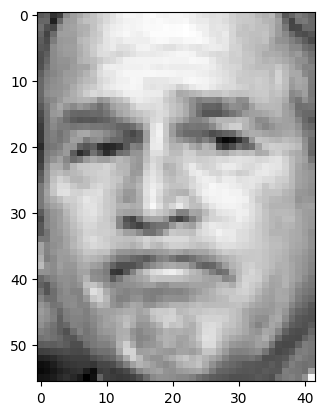

Количество фото: 1140
Количество политиков: 5


In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.45)

# Визуализация изображения
plt.imshow(lfw_people.images[0], cmap='gray')
plt.show()

# Количество фото и количество классов
print(f"Количество фото: {lfw_people.data.shape[0]}")
print(f"Количество политиков: {len(lfw_people.target_names)}")

## Classes distribution

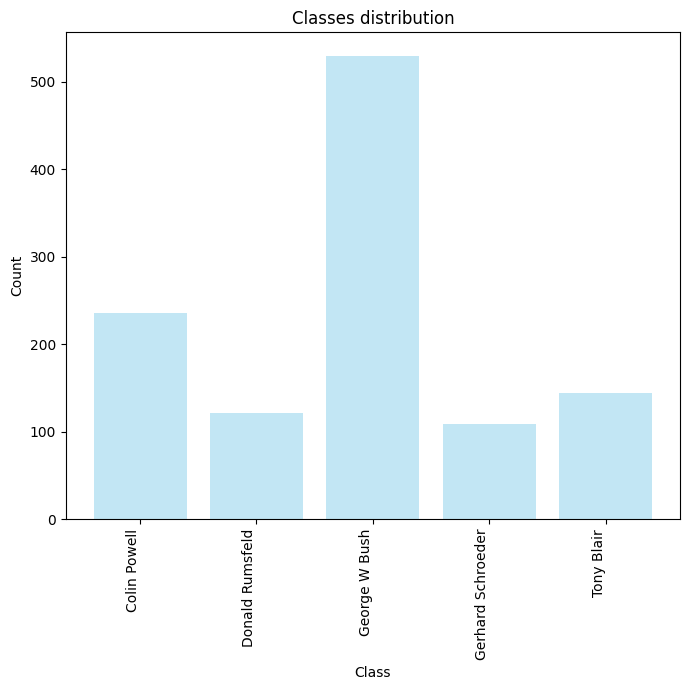

In [ ]:
counts = np.bincount(lfw_people.target)

fig, ax1 = plt.subplots(1,1, figsize=(7, 7))
ax1.bar(lfw_people.target_names, counts, color='skyblue', alpha=0.5)
ax1.set_title('Classes distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show();

Как можно видеть из графика - классы не являются сбалансированными. Фотографий Джоржа Буша значительно больше, чем остальных

# Train models

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X = lfw_people.images.reshape(len(lfw_people.images), -1)
y = lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 0. Dummy model

In [ ]:
model = DummyClassifier(random_state=42, strategy='most_frequent')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность случайной модели на тестовой выборке: {accuracy}")

Точность случайной модели на тестовой выборке: 0.4649122807017544


Использование случайной модели помогает определить, насколько лучше обученная модель по сравнению с константным прогнозом

## 1. Catboost

### 1.1 Base Catboost model

In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
model.fit(X_train, y_train)

Время обучения модели составило **63с**

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность базовой модели на тестовой выборке: {accuracy}")

Точность базовой модели на тестовой выборке: 0.8464912280701754


### 1.2 Tuned Catboost model

In [ ]:
# Подбор гиперпараметров
grid = {"depth": range(10)}

grid_search = GridSearchCV(model, grid, scoring='accuracy', cv=5, verbose=0)
grid_search.fit(X_train, y_train)

In [ ]:
# Лучшие гиперпараметры
best_params = grid_search.best_params_
print(f"Лучшие гиперпараметры: {best_params}")

Лучшие гиперпараметры: {'depth': 4}


In [ ]:
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"После подбора гиперпараметров точность на тестовой выборке: {accuracy}")

После подбора гиперпараметров точность на тестовой выборке: 0.8596491228070176


По итогам применения  CatBoost можем видеть, что модель с базовыми настройками выдает результат accuracy **84,6%**, а после подбора гиперпараметров **85,9%**, что показывает значительное превосходство моделей над константной.

## 2. Xboost

### 1.1 Base Xboost model

In [ ]:
model = XGBClassifier(n_estimators=1000, tree_method="hist", device="cuda")
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность базовой модели на тестовой выборке: {accuracy}")

Точность базовой модели на тестовой выборке: 0.8026315789473685


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:48:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### 1.2 Tuned Xboost model

In [ ]:
# Подбор гиперпараметров
grid = {
    'max_depth': range(1,5),
    'learning_rate': [0.3, 0.1, 0.01, 0.001],
    'subsample':[0.8, 0.9]}

grid_search = GridSearchCV(model, grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             param_grid={'learning_rate': [0.3, 0.1, 0.01, 0.001],
                         'max_depth': range(1, 5), 'subsample': [0.8, 0.9]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print(f"Лучшие гиперпараметры: {best_params}")

Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.9}


In [ ]:
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"После подбора гиперпараметров точность на тестовой выборке: {accuracy}")

После подбора гиперпараметров точность на тестовой выборке: 0.8640350877192983


По итогам применения Xboost после подбора гиперпараметров удалось поднять значение метрики с **80.2%** до **86.4%**. Качество оказалось на 0.5% выше, чем у Catboost

## 3. PCA with GB model

In [ ]:
# Понижение размерности данных
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
print(f"Размерности выборок после PCA:")
print(X_train_pca.shape, X_test_pca.shape)

print(f"Размерность пространства сократилась на {np.round((X_train.shape[1] - X_train_pca.shape[1]) / X_train.shape[1] * 100,2)}%")

Размерности выборок после PCA:
(912, 161) (228, 161)
Размерность пространства сократилась на 93.15%


In [ ]:
model = XGBClassifier(n_estimators=1000,
                      tree_method="hist",
                      device="cuda",
                      learning_rate= 0.1,
                      max_depth=2,
                      subsample=0.9)

model.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Время обучения на данных с сокращенной размерностью составило **9.78с**, против

**63с** на полноразмерных данных.

In [ ]:
# Оценка качества на данных с сокращенной размерностью
y_pred_pca = model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Точность Xboost на данных с сокращенной размерностью: {accuracy_pca}")

Точность Xboost на данных с сокращенной размерностью: 0.8596491228070176


In [ ]:
model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1', depth=4)
model.fit(X_train_pca, y_train)

In [ ]:
# Оценка качества на данных с сокращенной размерностью
y_pred_pca = model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Точность CatBoost на данных с сокращенной размерностью: {accuracy_pca}")

Точность CatBoost на данных с сокращенной размерностью: 0.8640350877192983


Сокращение размерности признакового пространства позволило  повысить качество предсказания модели Catboost ,а для модели Xboost качество на сокращенном принаковом пространстве, наоборот, немного снизилось. Само простарнство признаков сократилось на ~93%, а время обучения модели сократилось в **6 раз**.

Применение PCA позволяет выделить наиболее важные компоненты данных: алгоритм может выделить общие шаблоны или особенности, которые способствуют лучшей классификации.

## Confusion matrix

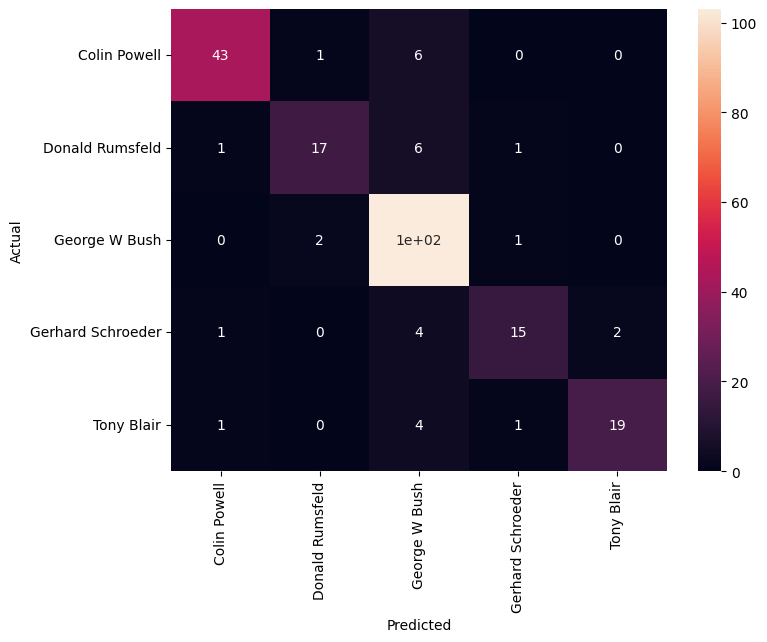

In [ ]:
# Вычисление матрицы ошибок на отложенной выборке
confusion_mat = confusion_matrix(y_test, y_pred_pca)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, xticklabels=lfw_people.target_names, yticklabels=lfw_people.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90        50
           1       0.85      0.68      0.76        25
           2       0.84      0.97      0.90       106
           3       0.83      0.68      0.75        22
           4       0.90      0.76      0.83        25

    accuracy                           0.86       228
   macro avg       0.87      0.79      0.83       228
weighted avg       0.87      0.86      0.86       228



Для того, чтобы оценить равнозначным ли было для модели распознавание  классов, оценим метрику recall,которая показывает, какую долю объектов из данного класса было правильно предсказано моделью.

Самый простой в распознавании класс - 2, самые сложные - 1 и 3. Скорее всего такая ситуация сложилась из-за того, что фотографий класса 2 в пять раз больше, чем фотографий 1 и 3.

## * Convolution Neural Network

In [ ]:
X = lfw_people.images
y = lfw_people.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(56, 42, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(lfw_people.target_names), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
23/23 [==============================] - 1s 13ms/step - loss: 1.4631 - accuracy: 0.4458 - val_loss: 1.4020 - val_accuracy: 0.4918
Epoch 2/20
23/23 [==============================] - 0s 6ms/step - loss: 1.4116 - accuracy: 0.4582 - val_loss: 1.3664 - val_accuracy: 0.4918
Epoch 3/20
23/23 [==============================] - 0s 6ms/step - loss: 1.3620 - accuracy: 0.4623 - val_loss: 1.2744 - val_accuracy: 0.5355
Epoch 4/20
23/23 [==============================] - 0s 6ms/step - loss: 1.2506 - accuracy: 0.5226 - val_loss: 1.1362 - val_accuracy: 0.6120
Epoch 5/20
23/23 [==============================] - 0s 6ms/step - loss: 1.0674 - accuracy: 0.5912 - val_loss: 1.0215 - val_accuracy: 0.6066
Epoch 6/20
23/23 [==============================] - 0s 6ms/step - loss: 0.8450 - accuracy: 0.6941 - val_loss: 0.7245 - val_accuracy: 0.7705
Epoch 7/20
23/23 [==============================] - 0s 6ms/step - loss: 0.6255 - accuracy: 0.7695 - val_loss: 0.7027 - val_accuracy: 0.7869
Epoch 8/20
23/23 [=

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

8/8 [==============================] - 0s 13ms/step - loss: 0.3295 - accuracy: 0.9035
Test Loss: 0.3295
Test Accuracy: 0.9035


# Summary

Задачей исследования было построение модели предсказания класса по изображению с наибольшим значением accuracy.

В ходе исследования были изучены предоставленные данные и оценено распределние изображений по классам.

Были рассмотрены несколько моделей классификации, а также был произведен поиск наилучшей модели. Для моделей Catboost и Xboost при помощи перебора по сетке с использованием кросс-валидации, были подобраны гиперпараметры, позволяющие получить лучшее качество в сравнении с бейзлайном. Рассматриваемые модели были сопоставлены с константной моделью. Стоит отметить тот факт, что для рассмотренных моделей предусмотрена возможность обучения на GPU, что сократило время обучения на 95%.

Для лучшей модели было оценено влияние снижения размерности признакового пространства на количество признаков, качество и скорость обучения.Для иллюстрации качества была построена матрица ошибок.

Лучшее качество было получено у модели **CatBoostClassifier(iterations=1000, depth=4)** на сокращенном PCA признаковом пространстве.
* Результирующее значение метрики  на тестовом множестве составило **86.4%**
* Время обучения **9.78с**

При сравнении результатов работы бустингового алгоритма со сверточной нейронной сетью оказалось, что качество предсказания ниже всего на ~1.5%, что показывает его конкурентноспособным в вопросах распознавания центрированных изображений.
